In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT
import db
import my_utils


# set_width_max_of_jupyterpad()
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
    
def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(np.dot(deviations**2,weights))
def list_rms(x):
  mean = sum(x)/len(x)
  deviations = x - mean
  return np.sqrt(sum(deviations**2) /len(x))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)
def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot

Welcome to JupyROOT 6.14/04


In [2]:
# define scan parameters:
channel_to_analyse = 4

# do not take data, but analyse existing scans: fit_only = 1
fit_only = 0

# threshold scan scurve fit quality limit to store results
chisquare_limit = 50

pt_pktime = 15
pt_gain = 4 
pt_threshold_default = 10

measure_board_list = ["0007","0011"]
# measure_board_list =  db.board_list_installed()




# type of trend scan:
# 1. scaling: one by one activation of PASTTREC boards 1-24
# 2. time trend : noise of on board as function of time
# 3. PASTTREC operation parameter scan (peaking time, gain, threshold)

#1. dependence on number of active boards:
# trend_scan_Xtitle = "number of active boards"  
# trend_scan_Nsteps = len(generate_neighbouring_w_board_list(measure_board_list[0]))
# data_output_dicrectory = "/workdir/data/scaling"

# 2. time dependence:
trend_scan_Nsteps = 3
time_between_scans = 6 
trend_scan_Xtitle = "time [{:.2f} minutes]".format(time_between_scans/60)
data_output_dicrectory = "/workdir/data/time"

# 3. gain dependence:
# trend_scan_Xtitle = "gain" ; 
# gain_list = [1,2,4]
# trend_scan_Nsteps = len(gain_list)
# data_output_dicrectory = "/workdir/data/gain"

1 . scan 
dumping data of board: 0007
0 0007 [4.5302910958404095]


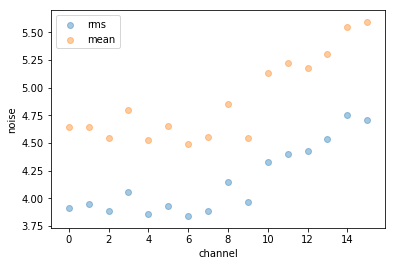

2 . scan 
dumping data of board: 0007
0 0007 [4.5302910958404095, 4.4881797214927417]


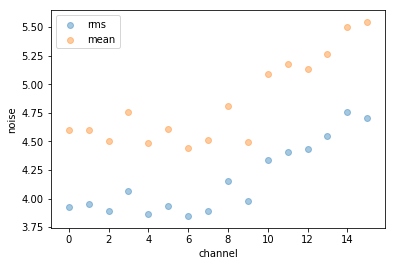

3 . scan 
dumping data of board: 0007
0 0007 [4.5302910958404095, 4.4881797214927417, 4.5356834206616288]


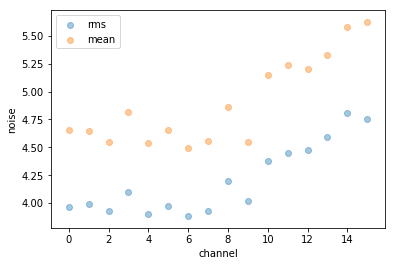

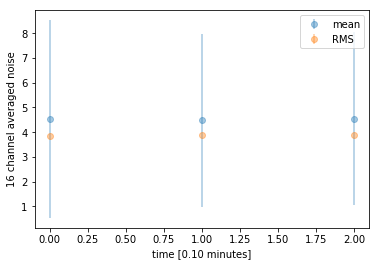

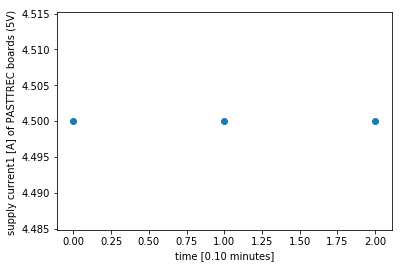

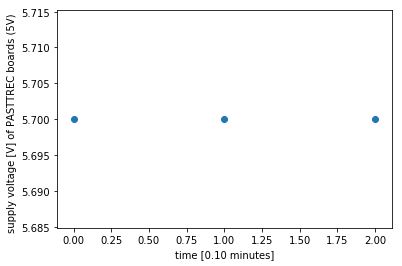

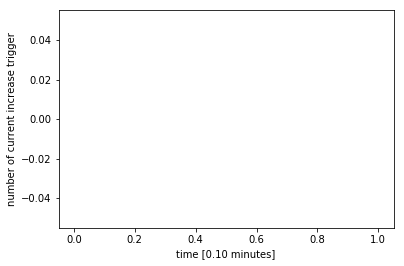

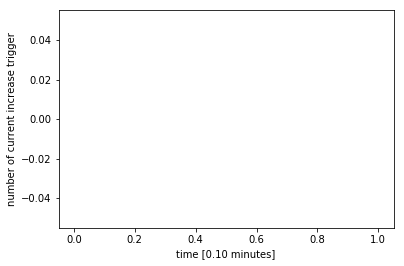

4 . scan 
dumping data of board: 0011
1 0011 [4.7168521604186733]


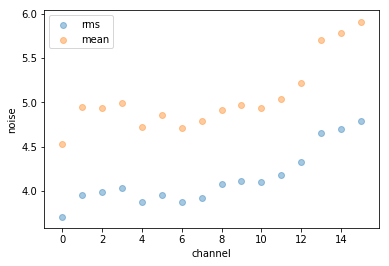

5 . scan 
dumping data of board: 0011
1 0011 [4.7168521604186733, 4.5418629777355362]


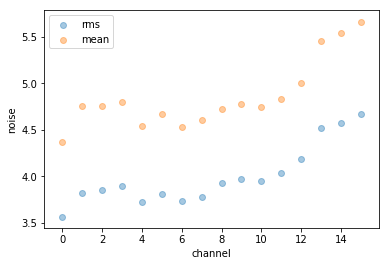

6 . scan 
dumping data of board: 0011
1 0011 [4.7168521604186733, 4.5418629777355362, 4.6153971946889216]


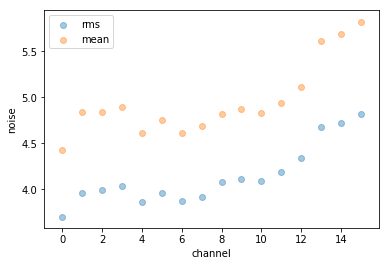

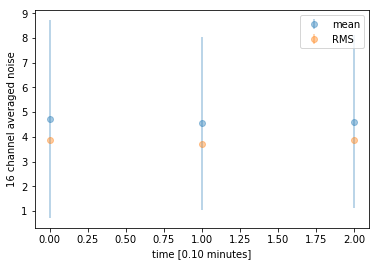

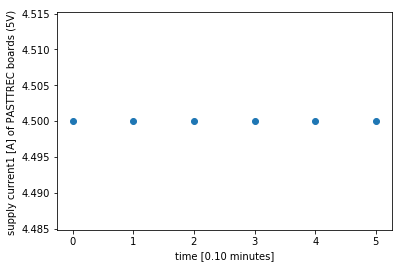

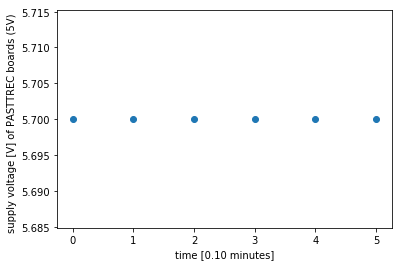

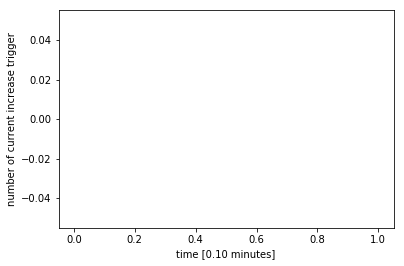

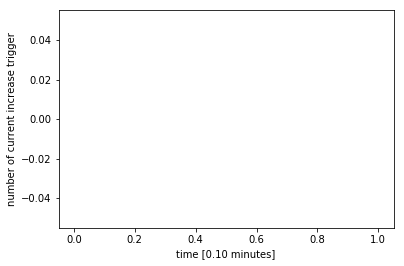

>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

In [3]:
import time
import tdc_daq as td
import matplotlib.pyplot as plt

import hameg_trb 


from my_utils import *
data_dir = make_data_dir()

from cw_pasttrec_functions import *




# arrays for PASTTREC power supply; current & volt trend
filelist = []
current_list = []
volt_list = []
boards_trigger_current_list = [[]*trend_scan_Nsteps,[]*trend_scan_Nsteps]
boards_trigger_number_list =  [[]*trend_scan_Nsteps,[]*trend_scan_Nsteps]
curr = [0,0]
# rmsAverageTrend_list       = [[]]*len(measure_board_list)
# rmsAverageTrendError_list  = [[]]*len(measure_board_list)
# meanAverageTrend_list      = [[]]*len(measure_board_list)
# meanAverageTrendError_list = [[]]*len(measure_board_list)

rmsAverageTrend_list       = [[],[]]
rmsAverageTrendError_list  =  [[],[]]
meanAverageTrend_list      =  [[],[]]
meanAverageTrendError_list =  [[],[]]

for name in measure_board_list: 
    if fit_only:
        continue
    # sequence of boards to activate:
    if "active boards" in trend_scan_Xtitle:
        boards_scan_list = generate_neighbouring_w_board_list(name)
    else:
        boards_scan_list = [name]*trend_scan_Nsteps
    #start with all boards inactive     
    for my_board in db.board_list():
           db.set_standby_board(my_board)
    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards(pt_pktime,pt_gain,pt_threshold_default)   
    
    for p in range(0,trend_scan_Nsteps):          
#     for p in wirelenght: 
        root_name = data_output_dicrectory + "/noise_" + name + "_scan0" + str(p) + ".root"
        for i in range(0,2): 
            curr[i] =    hameg_trb.get_curr(i+3)  
        filelist += [root_name]
        
        if "active boards" in trend_scan_Xtitle:
            # switch on one board after another (unset standby):
            print( str(len(boards_scan_list)) + " boards to activate, sequence of activation, boards list: ")
            print(boards_scan_list)
            for my_board in db.board_list():
                    if my_board == boards_scan_list[p]:
                        print(p," active boards, switched on board ", my_board) 
                        db.unset_standby_board(my_board)
                        ptc.init_board_by_name(my_board,pt_pktime,pt_gain,pt_threshold_default)    
        else:
            if "time" in trend_scan_Xtitle:
                time.sleep(time_between_scans) 
            if "gain" in trend_scan_Xtitle:
                # set gain of all active PASTTRECS:
                for pt_gain in gain_list:
                    ptc.init_active_boards(pt_pktime,pt_gain,pt_threshold_default)    
                
        
        # read power usage of PASTTREC boards:
        current_list += [ hameg_trb.get_curr(3) ]
        volt_list += [ hameg_trb.get_volt(3) ]
        for i in range(0,2): 
            if abs(hameg_trb.get_curr(i+3) - curr[i]) > 0.002:
                boards_trigger_current_list[i] += [boards_scan_list[p]]
                boards_trigger_number_list[i]  += [p]
                print("board switched on at current change: ", i, p , boards_scan_list[p],curr[i], hameg_trb.get_curr(i+3))
        # pause for not killing trb by sending to many parallel commands regiser writes:
        time.sleep(5) 
        ptc.init_active_boards(pt_pktime,pt_gain,pt_threshold_default) 
        print(len(filelist),". scan ")
        
#         baseline_calib.baseline_calib_by_noise(name, dummy_calib=True) 
#         baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True) 
        baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)        
        db.dump_db_to_root_board(root_name,name)
        #read threshold_scan from database:
        dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
        tsbl_scan_raw = dummy_calib["tsbl_scan_raw"]
        tsbl_range    = dummy_calib["tsbl_range"]
        

        rms_list = []
        mean_list = []
       
        for i in range(0,16):
              rms_list += [ hist_rms(tsbl_range,tsbl_scan_raw[i]) ]
              mean_list += [ MeanArrays(tsbl_range,tsbl_scan_raw[i]) ]  

         # calculate noise mean over 16 channels of single board
#         meanAverageTrend_list += [ sum(mean_list)/len(mean_list) ]
#         meanAverageTrendError_list += [ list_rms(mean_list) ]
#         rmsAverageTrend_list += [ sum(rms_list)/len(rms_list) ]
#         rmsAverageTrendError_list += [ list_rms(rms_list) ]   
# channel_to_analyse        
        board_index = measure_board_list.index(name)

        meanAverageTrend_list[board_index] += [ mean_list[channel_to_analyse] ]
        meanAverageTrendError_list[board_index] += [0.5*fwhm(tsbl_range,tsbl_scan_raw[channel_to_analyse]) ]
        rmsAverageTrend_list[board_index] += [ rms_list[channel_to_analyse] ]
        rmsAverageTrendError_list[board_index] += [ 0 ] 
        print(board_index, name, meanAverageTrend_list[board_index])
        plt.scatter(range(0,len(rms_list)),rms_list, alpha=0.4,label = "rms")
        plt.scatter(range(0,len(mean_list)),mean_list, alpha=0.4,label = "mean")        
        plt.xlabel("channel")
        plt.ylabel("noise")
        plt.legend()
#         plt.savefig("noise_channels.png", bbox_inches='tight')       
        plt.show()
        #end of switch on scan loop

    
    plt.errorbar(range(0,len(meanAverageTrend_list[board_index])),meanAverageTrend_list[board_index], meanAverageTrendError_list[board_index], xerr=None, fmt='o', alpha=0.4,label = "mean")  
    plt.errorbar(range(0,len(rmsAverageTrend_list[board_index])),rmsAverageTrend_list[board_index], rmsAverageTrendError_list[board_index], xerr=None, fmt='o', alpha=0.4,label = "RMS")
    plt.xlabel(trend_scan_Xtitle)
    plt.ylabel("16 channel averaged noise")
    plt.legend()
    plt.show()    
    
    # plots showing triggering of PASTTREC power cosumption change during scan:
    plt.scatter(range(0,len(current_list)),current_list)
    plt.xlabel(trend_scan_Xtitle)
    plt.ylabel("supply current1 [A] of PASTTREC boards (5V) ")
    plt.show()

    plt.scatter(range(0,len(volt_list)),volt_list)
    plt.xlabel(trend_scan_Xtitle)
    plt.ylabel("supply voltage [V] of PASTTREC boards (5V)  ")
    plt.show()

    for i in range(0,2):
     plt.hist(boards_trigger_current_list[i], len(boards_scan_list) )
     plt.xlabel(trend_scan_Xtitle)
     plt.ylabel("number of current increase trigger")
    plt.show()
    for i in range(0,2):
     plt.hist(boards_trigger_number_list[i], len(boards_scan_list) )
     plt.xlabel(trend_scan_Xtitle)
     plt.ylabel("number of current increase trigger")
    plt.show()


number of scan  1
/workdir/data/time/noise_0007_scan00.root
channel 4, noise threshold half max V] = 6.85
/workdir/data/time/noise_0007_scan01.root
channel 4, noise threshold half max V] = 6.46
/workdir/data/time/noise_0007_scan02.root
channel 4, noise threshold half max V] = 6.02
[4.5302910958404095, 4.4881797214927417, 4.5356834206616288]
[4.7168521604186733, 4.5418629777355362, 4.6153971946889216]


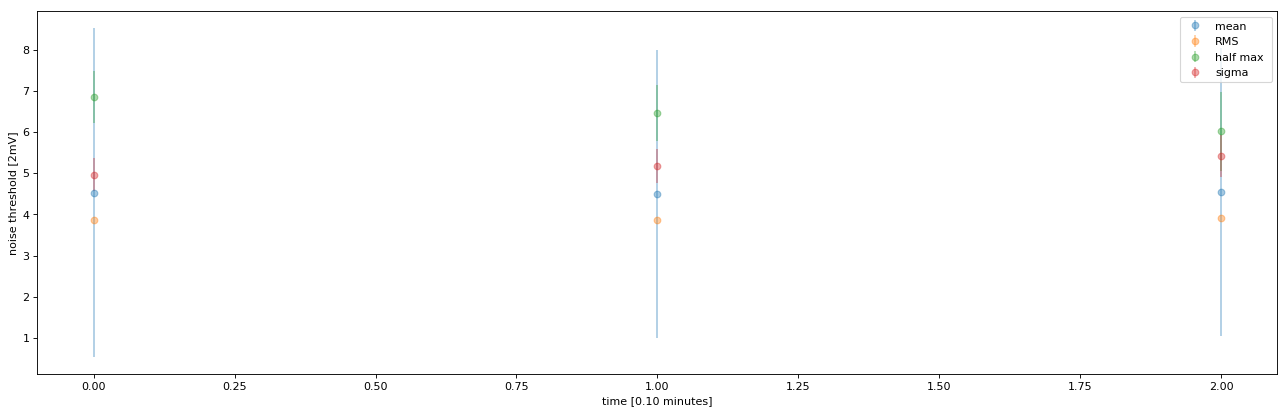

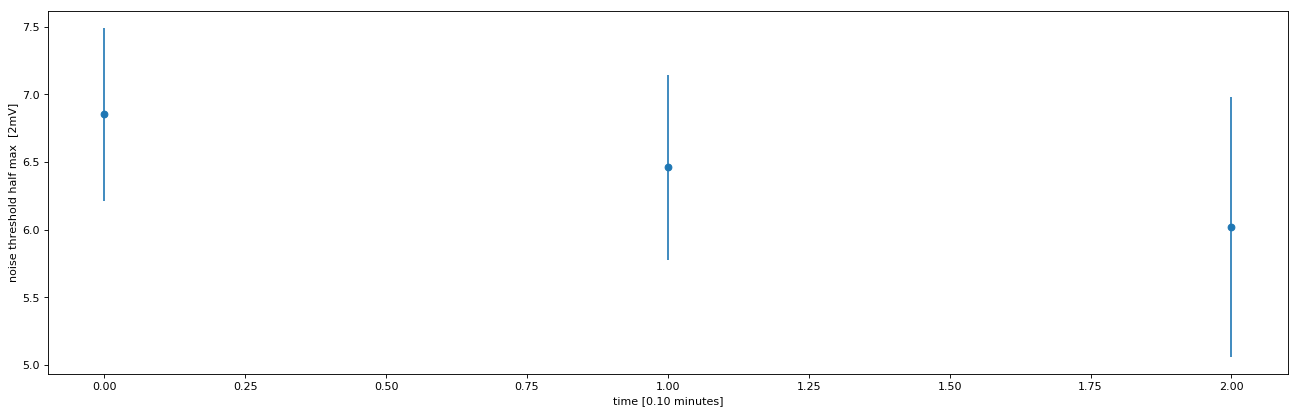

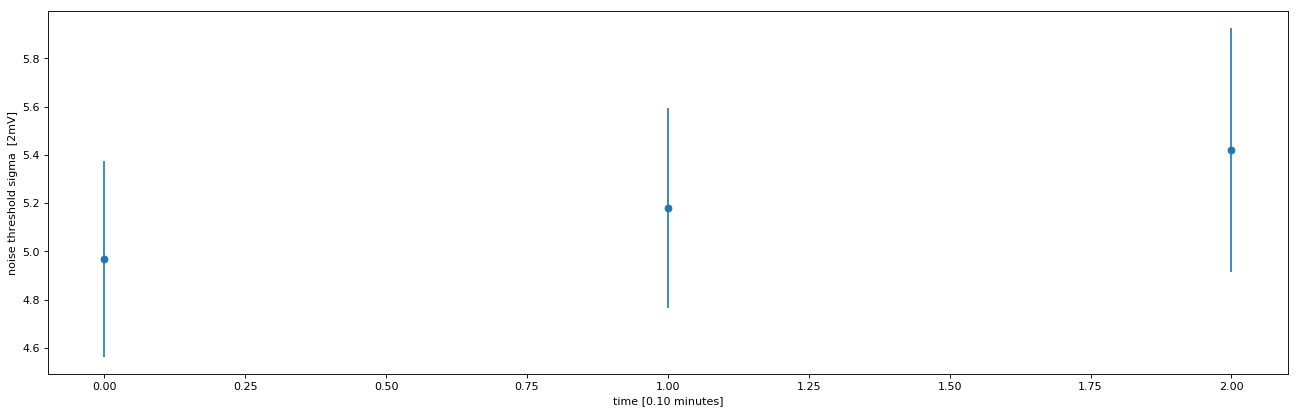

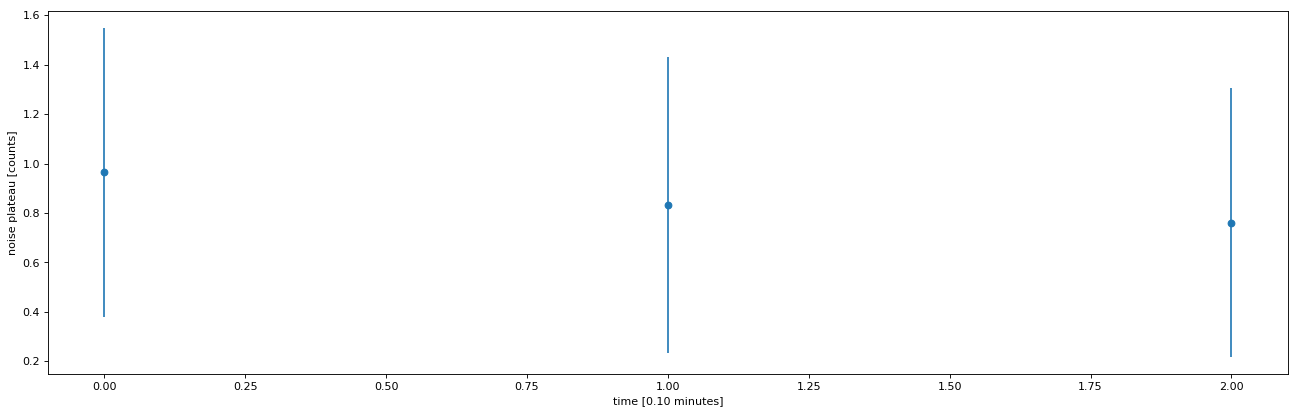

number of scan  2
/workdir/data/time/noise_0011_scan00.root
channel 4, noise threshold half max V] = 7.03
/workdir/data/time/noise_0011_scan01.root
channel 4, noise threshold half max V] = 5.87
/workdir/data/time/noise_0011_scan02.root
channel 4, noise threshold half max V] = 6.87
[4.5302910958404095, 4.4881797214927417, 4.5356834206616288]
[4.7168521604186733, 4.5418629777355362, 4.6153971946889216]


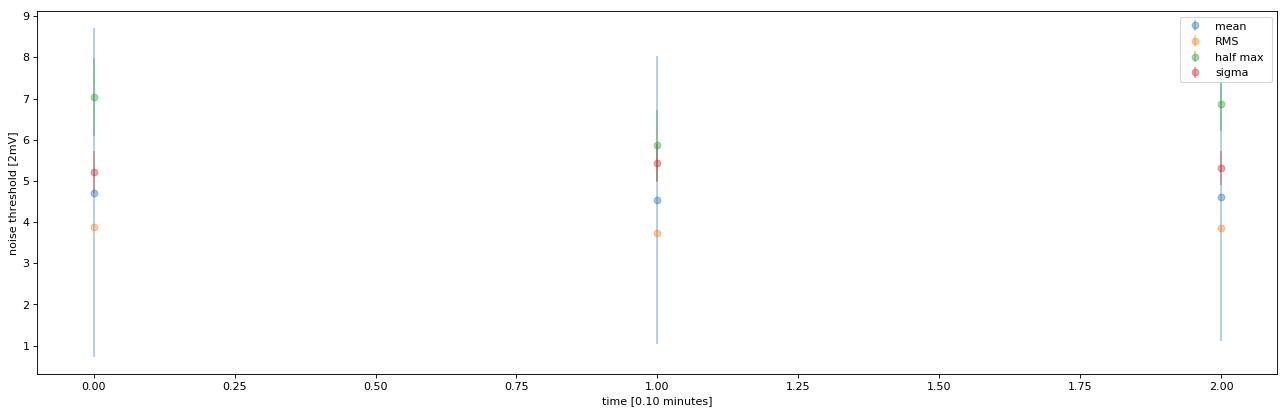

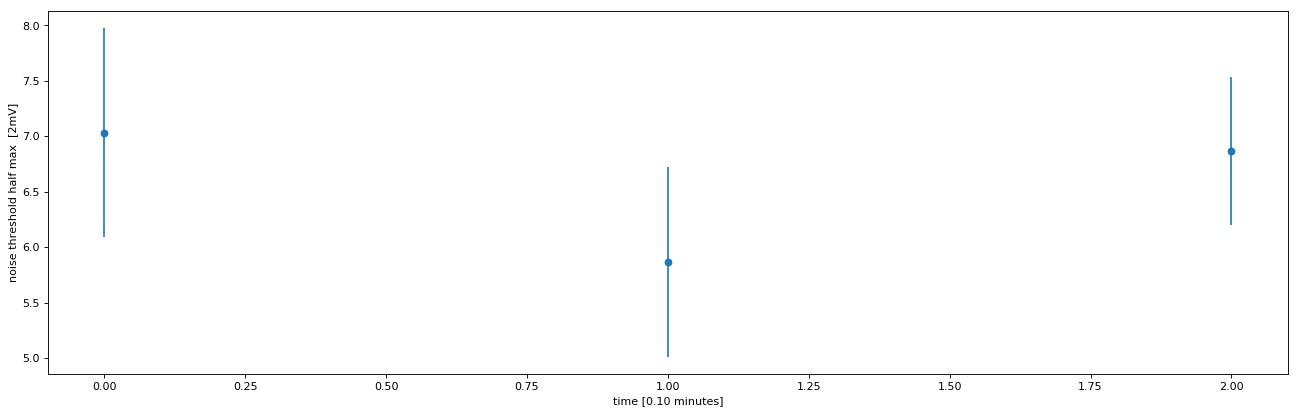

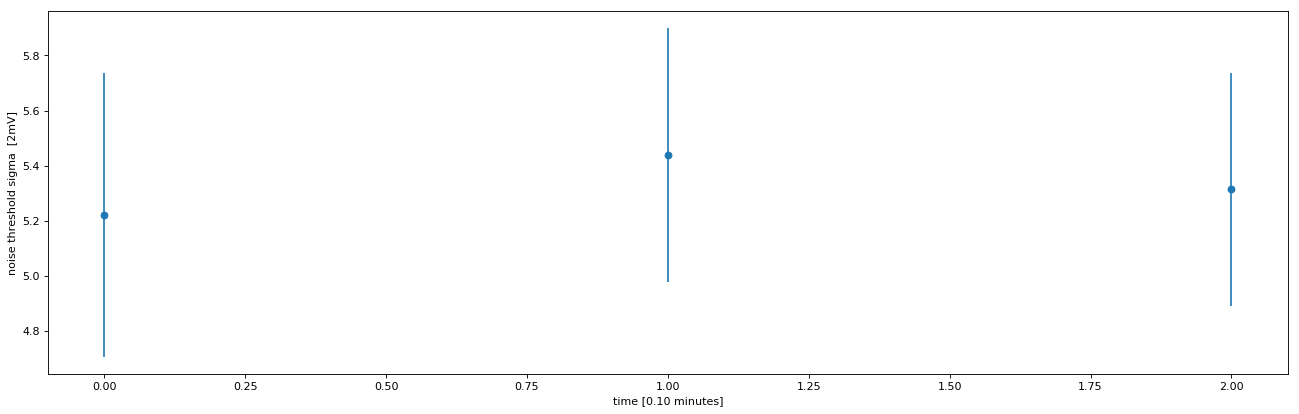

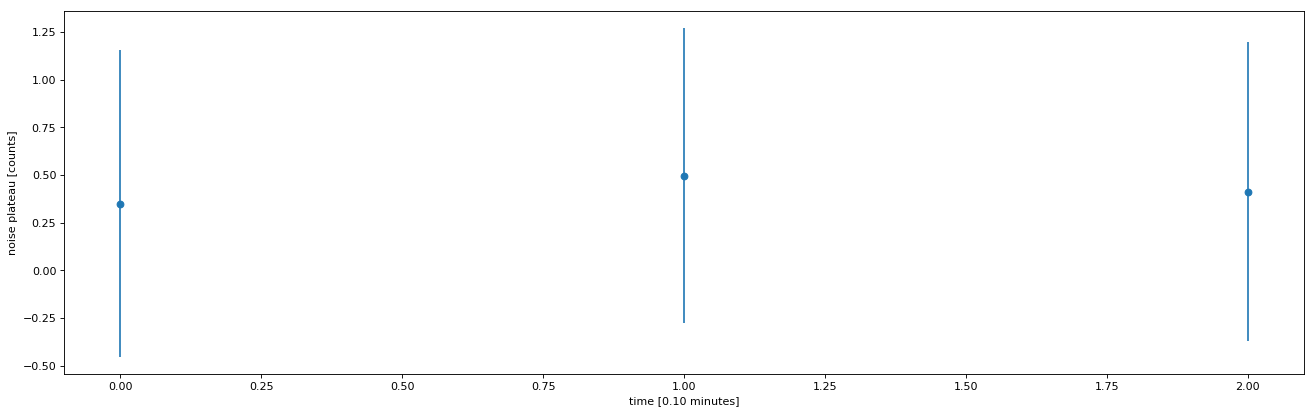

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /workdir/data/time/fit/0007/noiseFit_lay3_wire132_scan000.png has been created
Info in <TCanvas::Print>: png file /workdir/data/time/fit/0007/noiseFit_lay3_wire132_scan001.png has been created
Info in <TCanvas::Print>: png file /workdir/data/time/fit/0007/noiseFit_lay3_wire132_scan002.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TList::Delete>: A list is accessing an object (0x6d23c40) already deleted (list name = TList)
Error in <TList::Delete>: A list is accessing an object (0x4a5d420) already deleted (list name = TList)
Error in <TList::Delete>: A list is accessing an object (0x6957830) already deleted (list name = TList)
Error in <TList::Delete>: A list is accessing an object (0x6d95870) already deleted (list name = TList)
Error in <TList::Delete>: A list is accessing an object (0x6db64d0) already deleted (list name = TList)


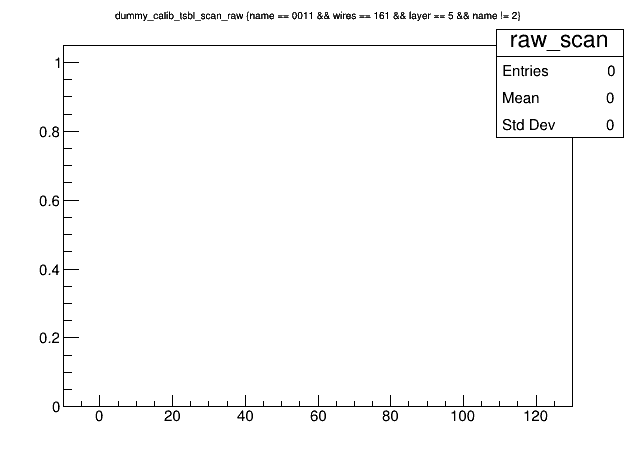

In [4]:
# analyse/fit results noise dpendence:
# print(filelist)
gif_out_list = []
import root_fit as fit
import os.path
from cw_pasttrec_functions import *

# clear older fit plots
fit_dir = data_output_dicrectory + "/fit"
if not os.path.isdir(fit_dir):
        os.mkdir(fit_dir)
else:
    os.system("rm -rf {:s}/*".format(fit_dir))


noise_turning_point = []*len(measure_board_list)
noise_sigma = []*len(measure_board_list)
noise_offset = []*len(measure_board_list)
noise_plots = ["half max","sigma","offset"]
noise_plots_data = [[]*len(measure_board_list)]*len(noise_plots)
noise_plots_data_x = []*len(measure_board_list)

for name in measure_board_list: 
    print("number of scan ", 1+len(noise_turning_point))
    boards_scan_list = generate_neighbouring_w_board_list(name)
    fit_dir = fit_dir + "/{:s}".format(name)
    os.mkdir(fit_dir)
    gif_out_list += [fit_dir]
    color_contrast_array = [1,632,600,417,800,616,401,880,807,633,634,626,797,617,618,622]
    c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
    ROOT.gStyle.SetOptFit(1)
    n_wires = 162
    mg = ROOT.TMultiGraph()
    mg2 = ROOT.TMultiGraph()
    mgDep = ROOT.TMultiGraph()
    legend = ROOT.TLegend(0.1,0.9,0.3,0.99);
#     gr = [0]*len(filelist)
#     gr2 = [0]*len(filelist)
    gr = [0]*600
    gr2 = [0]*600    
    grDep = [0]*16
    dependency_list = []
    c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
    index_l = -1
    # for p in [1,2,4]:   # PASTTREC gain scan
    #for p in [1,2,4]:   # PASTTREC peakingtime scan
    gr3 = ROOT.TGraphErrors(); 
    noise_by_dependency_list = [] 
    noise_by_dependency_list_sigma = []
    noise_by_dependency_list_offset = []
    noise_by_dependency_list_err = [] 
    noise_by_dependency_list_sigma_err = []
    noise_by_dependency_list_offset_err = []
    
    for index_channel in range(0,16): 
        grDep[index_channel] = ROOT.TGraphErrors(); 
        grDep[index_channel].SetMarkerStyle(3+index_channel);
        grDep[index_channel].SetMarkerColor(color_contrast_array[index_channel]); 
        grDep[index_channel].SetLineColor(color_contrast_array[index_channel]);   
    canID = 0
    for p in range(0,trend_scan_Nsteps):
#     for p in range(0,100):        
        canID += 1
        cscan = ROOT.TCanvas("cscan" + str(canID),"The Canvas Title",640,480); cscan.cd();
        dependency_list += [ p ]
        root_name = data_output_dicrectory + "/noise_" + name + "_scan0" + str(p) + ".root"
#         if root_name not in filelist:
        if not os.path.isfile(root_name):
                continue
        print(root_name)
        f = ROOT.TFile(root_name)
        dummy_tsbl_tree = f.Get("dummy_tsbl_tree")
        index_l += 1
        gr[index_l] = ROOT.TGraphErrors(); 
    #     gr[index_l].SetMarkerStyle(3+index_l); gr[index_l].SetMarkerColor(color_contrast_array[index_l]); 
    #     gr[index_l].SetLineStyle(2); gr[index_l].SetLineColor(color_contrast_array[index_l]);
        gr2[index_l] = ROOT.TGraphErrors(); gr2[index_l].SetMarkerStyle(3+index_l);

    #     gr2[index_l].SetMarkerStyle(3+index_l); gr2[index_l].SetMarkerColor(color_contrast_array[index_l]); 
    #     gr2[index_l].SetLineStyle(2); gr2[index_l].SetLineColor(color_contrast_array[index_l]);    
        for l in range(0,6):
    #         index_l += 1
            stdev_list = []
            sigma_list = []
            mean_list = []    
            sigma_list_err = []
            mean_list_err = []  
            ipoint = 0
            for i in range(0,n_wires):
               cscan.cd() 
               ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw>>raw_scan(140,-10,130)","name == " + name + " && wires == " + str(i) + " && layer == " + str(l) + " && name != " + str(p)  )
               if (ndata > 0): 
                   raw_scan = f.Get("raw_scan")
                   results = fit.fit_scurve(raw_scan,-1, chisquare_limit)
                   
                   raw_scan.DrawCopy()
                   cscan.Draw()
#                    cscan.Update()
                   fit_picture_file = fit_dir+"/noiseFit_lay" + str(l) +"_wire{:03d}_scan{:03d}".format(i,p) +".png"
#                    cscan.SaveAs(fit_picture_file)
                   gr[index_l].SetPoint(ipoint, i, np.double(results[2]))
                   gr[index_l].SetPointError(ipoint, 0, np.double(results[3]) )
                   gr2[index_l].SetPoint(ipoint, i, np.double(results[4]))
                   gr2[index_l].SetPointError(ipoint, 0, np.double(results[5]) )
                   if(ipoint == channel_to_analyse ):
#                        
                       cscan.SaveAs(fit_picture_file)
                       print("channel " + str(ipoint) + ", noise threshold half max [2mV] = {:.2f}".format(results[2]) )
                       gr3.SetPoint(p, p, np.double(results[2]))
                       gr3.SetPointError(p, 0, np.double(results[3]))
                       noise_by_dependency_list += [results[2]]
                       noise_by_dependency_list_err += [results[3]]                    
                       noise_by_dependency_list_sigma += [results[4]]
                       noise_by_dependency_list_sigma_err += [results[5]]                    
                       noise_by_dependency_list_offset += [results[6]]
                       noise_by_dependency_list_offset_err += [results[7]]                    
                   grDep[ipoint].SetPoint(p, p, np.double(results[2]))
                   grDep[ipoint].SetPointError(p, 0, np.double(results[3]) )  
                   ipoint += 1

        mg.Add(gr[index_l]); gr[index_l].SetTitle("layer " + str(l) ); 
        mg2.Add(gr2[index_l]); gr2[index_l].SetTitle("layer " + str(l) );  
        for index_channel in range(0,16):   
            mgDep.Add(grDep[index_channel]); grDep[index_channel].SetTitle("wire " + str(index_channel) );  

       #legend->SetHeader("The Legend Title","C"); // option "C" allows to center the header
        legend.AddEntry(gr[index_l],"gain " + str(p),"lp")
        
    noise_turning_point += [noise_by_dependency_list]
    noise_sigma += [noise_by_dependency_list_sigma]
    noise_offset += [noise_by_dependency_list_offset]
    noise_plots_data[0] += [noise_by_dependency_list]
    noise_plots_data[1] += [noise_by_dependency_list_sigma] 
    noise_plots_data[2] += [noise_by_dependency_list_offset]
    noise_plots_data_x += [boards_scan_list]
    
    if "active boards" in trend_scan_Xtitle:
        plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.scatter(boards_scan_list[:len(noise_by_dependency_list)],noise_by_dependency_list,alpha=0.9,label = "{:d}".format(1))
        plt.xlabel("board active")
        plt.ylabel("noise threshold half max [2mV]")
        plt.show()

    board_index = measure_board_list.index(name)    
    print(meanAverageTrend_list[0])
    print(meanAverageTrend_list[1])
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(range(0,len(meanAverageTrend_list[board_index])),meanAverageTrend_list[board_index], meanAverageTrendError_list[board_index], xerr=None, fmt='o', alpha=0.4,label = "mean")  
    plt.errorbar(range(0,len(rmsAverageTrend_list[board_index])),rmsAverageTrend_list[board_index], rmsAverageTrendError_list[board_index], xerr=None, fmt='o', alpha=0.4,label = "RMS")
    plt.errorbar(range(0,len(noise_by_dependency_list)),noise_by_dependency_list, noise_by_dependency_list_err, xerr=None, fmt='o', alpha=0.4,label = "half max ")
    plt.errorbar(range(0,len(noise_by_dependency_list)),noise_by_dependency_list_sigma, noise_by_dependency_list_sigma_err, xerr=None, fmt='o', alpha=0.4,label = "sigma")
    
    plt.xlabel(trend_scan_Xtitle)
    plt.ylabel("noise threshold [2mV]")
    plt.legend()
    plt.show()    
    
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(range(0,len(noise_by_dependency_list)),noise_by_dependency_list, noise_by_dependency_list_err, xerr=None, fmt='o')
    plt.xlabel(trend_scan_Xtitle)
    plt.ylabel("noise threshold half max  [2mV]")
    plt.show()    
                    
    
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(range(0,len(noise_by_dependency_list)),noise_by_dependency_list_sigma, noise_by_dependency_list_sigma_err, xerr=None, fmt='o')
    plt.xlabel(trend_scan_Xtitle)
    plt.ylabel("noise threshold sigma  [2mV]")
    plt.show()
    
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(range(0,len(noise_by_dependency_list)),noise_by_dependency_list_offset, noise_by_dependency_list_offset_err, xerr=None, fmt='o')
    plt.xlabel(trend_scan_Xtitle)
    plt.ylabel("noise plateau [counts]")
    plt.show()
  

[4.5302910958404095, 4.4881797214927417, 4.5356834206616288]


IndexError: list index out of range

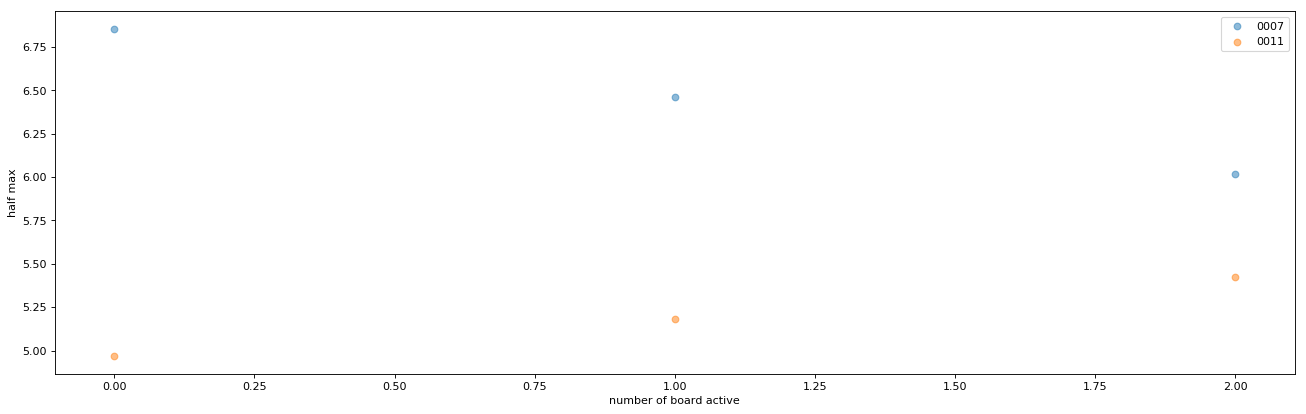

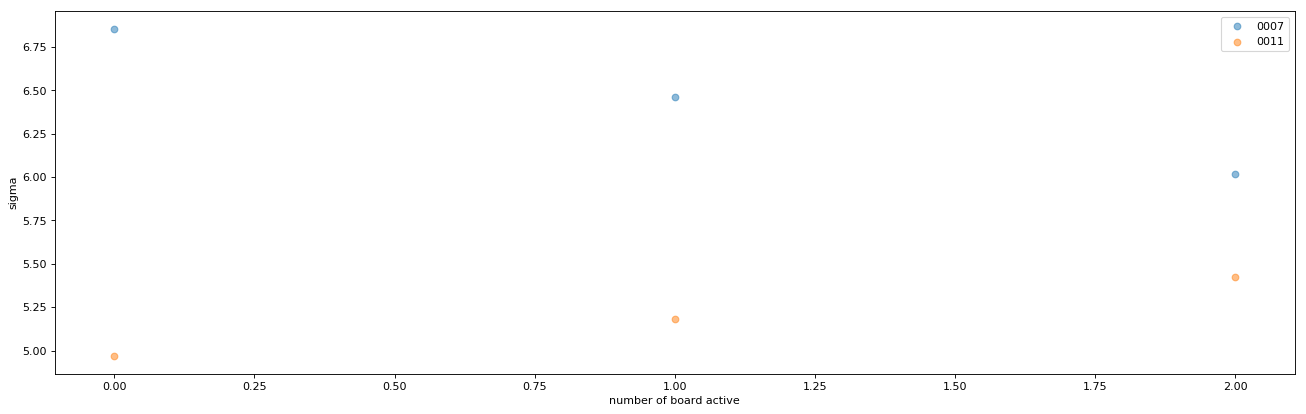

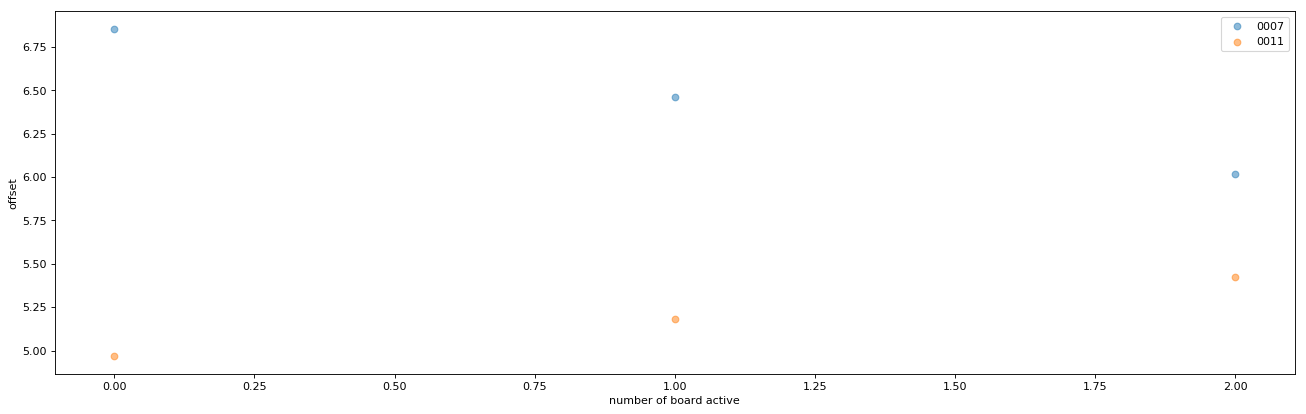

ValueError: x and y must be the same size

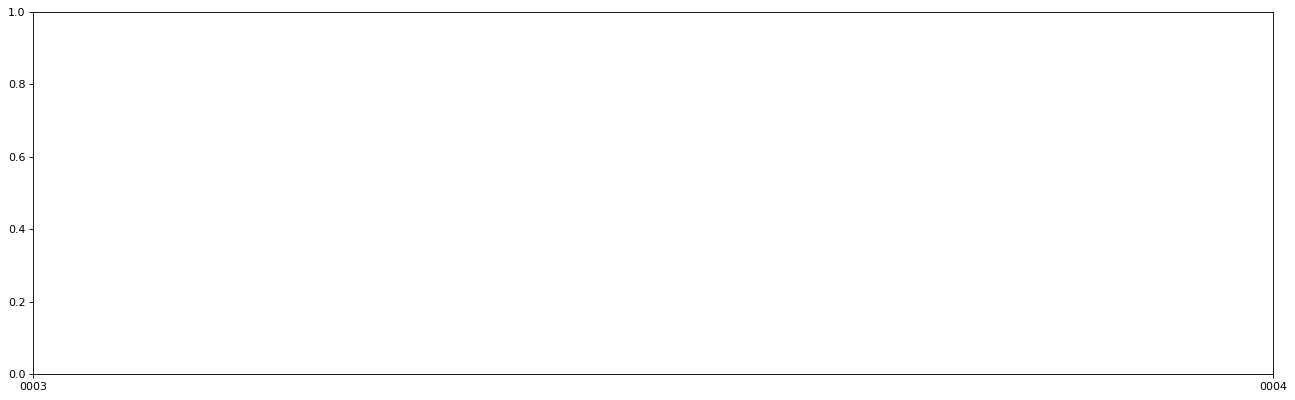

In [6]:
# print(noise_plots_data)

pl=-1
for plot_name in noise_plots: 
    pl += 1
    b = 0
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    for name in measure_board_list:
        plt.scatter(range(0,len(noise_plots_data[pl][b])),noise_plots_data[pl][b],alpha=0.5,label = name)     
        b += 1
    plt.xlabel("number of board active")
    plt.ylabel(plot_name)
    plt.legend()
    plt.show()

plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pl=-1
for plot_name in noise_plots: 
    pl += 1
    b = 0
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    for name in measure_board_list:
        plt.scatter(noise_plots_data_x[b],noise_plots_data[pl][b],alpha=0.5,label = name)     
        b += 1
    plt.xlabel("board activated")
    plt.ylabel(plot_name)
    plt.legend()
    plt.show()

In [ ]:
from IPython.display import Image
## display all single channel threshold scan fits into an animated gif

# gif_out_list = ["/workdir/data/noise/fit/"]
for subfolder in sorted(list(set(gif_out_list))):
        print("animating graphics in {:s}".format(subfolder))
        print(subfolder)
        os.system("cd  {:s}; convert -alpha off -delay 100 -loop 0 *png output.gif ".format(subfolder))
        with open('{:s}/output.gif'.format(subfolder),'rb') as f:
            display(Image(data=f.read(), format='png'))


In [ ]:
#archive(label="power_supply_trend_on_switching_on_boards")

In [ ]:


c3 = ROOT.TCanvas("c3","The Canvas Title",640,480); c3.cd();
gr3.Draw("a*p")
gr3.GetXaxis().SetTitle("number of active boards");
gr3.GetYaxis().SetTitle("noise threshold half max [2mV]");
# gr3.GetYaxis().SetRangeUser(0,40)
gr3.Draw("a*p")
c3.Draw()

c1 = ROOT.TCanvas("c1","The Canvas Title",640,480); c1.cd();
mg.Draw("ap")
mg.GetXaxis().SetTitle("wire number");
mg.GetYaxis().SetTitle("noise threshold half max (DAC)");
# mg.GetYaxis().SetRangeUser(4,6)
mg.Draw("ap")
legend.Draw()
c1.Draw()
c2 = ROOT.TCanvas("c2","The Canvas Title",640,480); c2.cd();
c2.cd();
mg2.Draw("ap")
mg2.GetXaxis().SetTitle("wire number");
mg2.GetYaxis().SetTitle("noise threshold sigma (DAC)");
# mg2.GetYaxis().SetRangeUser(-1,2)
mg2.Draw("ap")
legend.Draw()
c2.Draw()

cDep = ROOT.TCanvas("cDep","The Canvas Title",640,480); cDep.cd();
mgDep.Draw("ap")
mgDep.GetXaxis().SetTitle("number of active boards");
mgDep.GetYaxis().SetTitle("noise threshold half max [2mV]");
# mgDep.GetYaxis().SetRangeUser(-500,120)
mgDep.Draw()
legend.Draw()
cDep.Draw()

# c1.SaveAs("board" + name + "_scan_mean.root")
# c2.SaveAs("board" + name + "_scan_sigma.root")
# c3.SaveAs("board" + name + "_noise_vs_no_active_boards.root")
# cDep.SaveAs("board" + name + "_noise_vs_no_active_boards_allchan.root")    


In [ ]:
for i in range(0,16):
    plt.scatter(tsbl_range,tsbl_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

    plt.legend()
    plt.xlabel("threshold (at maximum baseline setting)")
    plt.ylabel("mean pulse rate (Hz)")
    #plt.yscale('log') 
    plt.show()